In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
                              get_within_perf_from_kfold_dict, cv_solve, solver_kwargs,
                                       predict_y_from_kfold_dict)
                              
from analysis.prediction_utils import make_train_pred_scatterplot as make_scatterplot

import matplotlib
import copy

/home/groups/smhsiang/venv/hdi/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
## Text save setting for AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# plotting vars

axis_label_size = 21
plot_title_size = 22
performance_size = 22
sup_title_size = 24

In [4]:
tick_size = 18.5

matplotlib.rcParams['xtick.labelsize'] = tick_size 
matplotlib.rcParams['ytick.labelsize'] = tick_size 

### Get data for HDI scatter

In [5]:
##training set dataframe created in code/analysis/hdi_and_iwi_model_training.ipynb\
tasks = ["Sub-national HDI"]

train_df = pd.read_pickle(data_dir + "model_data/full_training_df.p")

In [6]:

## Model data object created in code/analysis/hdi_and_iwi_model_training.ipynb

path = (data_dir+"model_data/"+
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=GHS_VIIRS_hist_bins_GHS_pop_weighted.pkl")

nl_and_rcf_demeaned_kfold_dict = pickle.load(open(path, "rb"))


In [7]:
df = get_within_perf_from_kfold_dict(nl_and_rcf_demeaned_kfold_dict, tasks[0], metric="ALL", return_df=True, 
                                     demeaned_input=True, not_demeaned_df=train_df)

In [8]:
fra  = df[df["country"] == "FRA"]
eth  = df[df["country"] == "ETH"]

/tmp/ipykernel_23590/2773790677.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


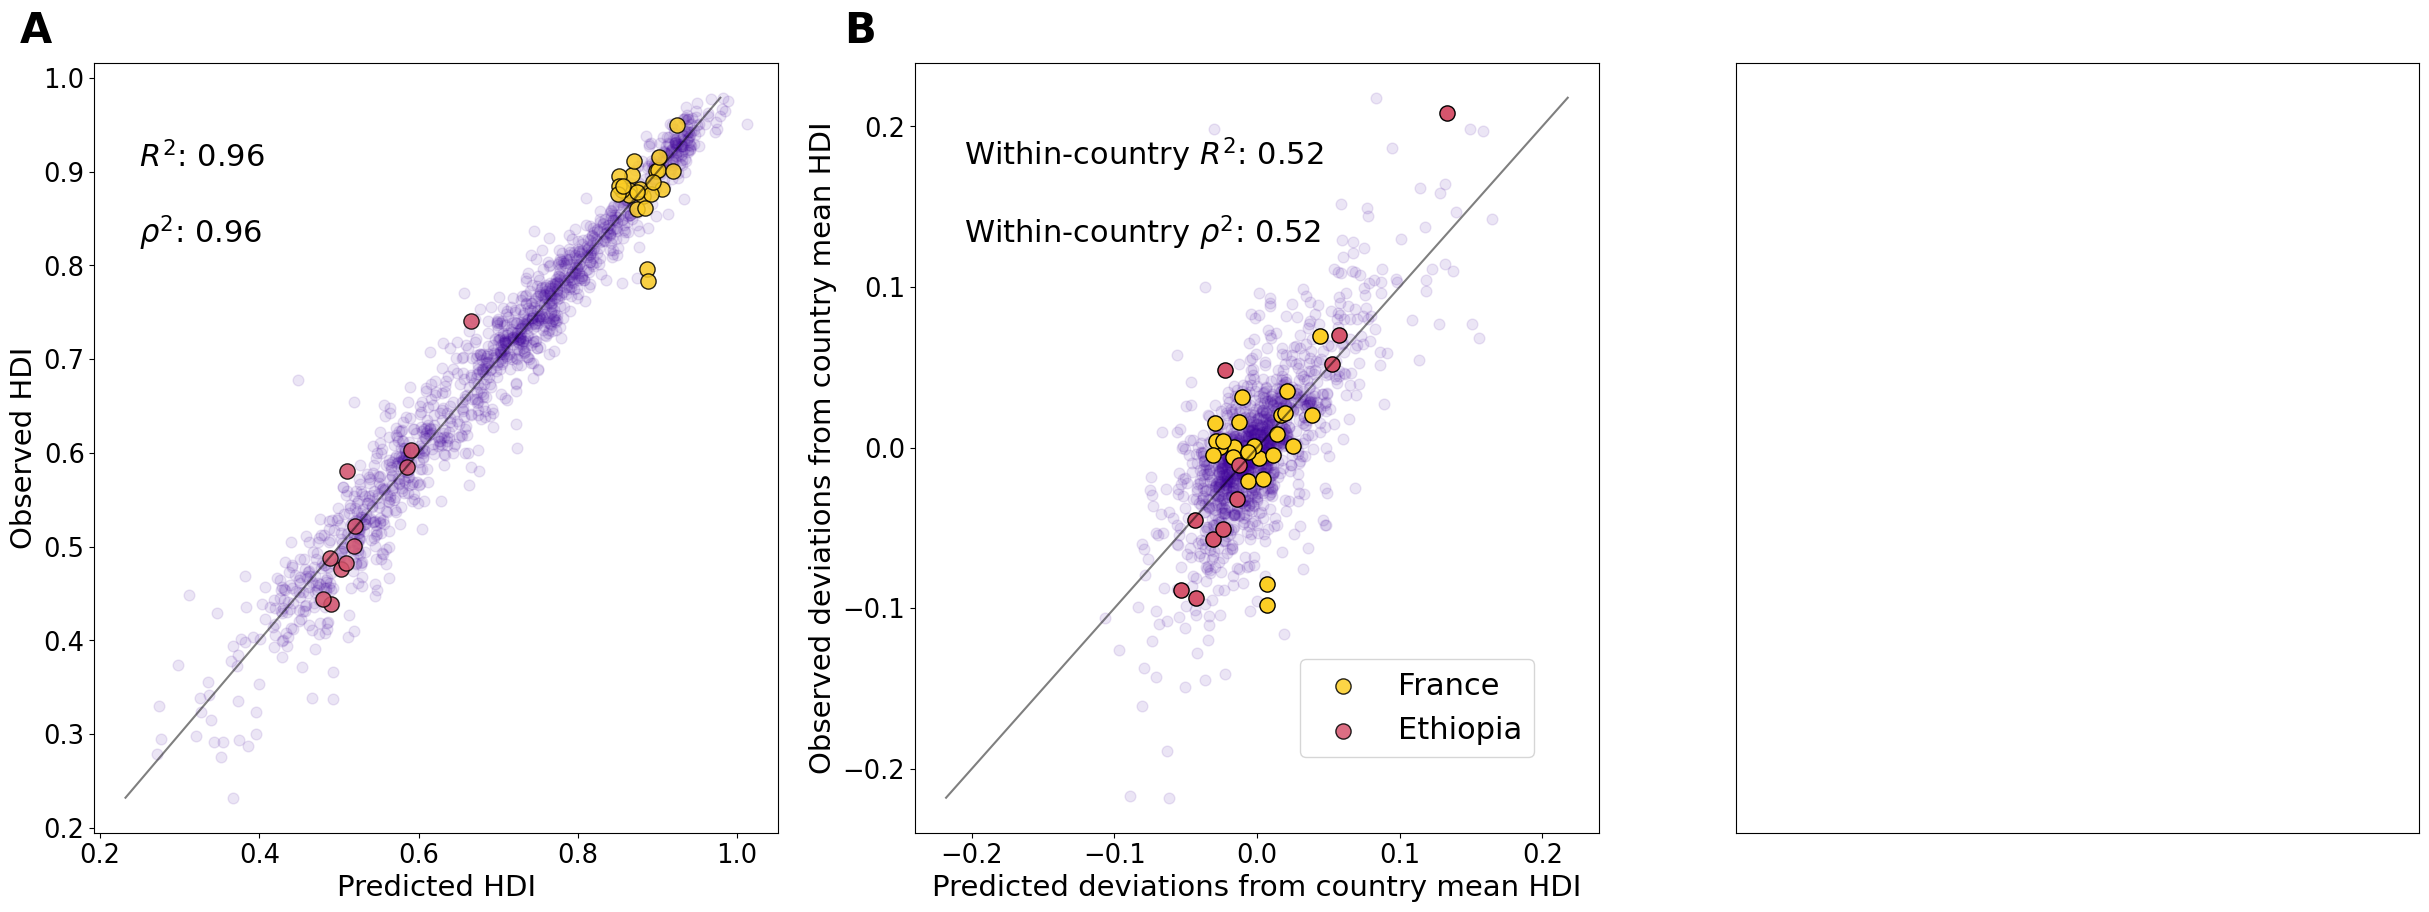

In [9]:
cmap = matplotlib.cm.get_cmap('plasma')

color1 = cmap(0.55)
color2 = cmap(0.9)
color3 = cmap(0.1)

fig1, ax = plt.subplots(1,3, figsize = (30,10))

ax[0].plot([df.truth.min(), df.truth.max()],[df.truth.min(), df.truth.max()], color='black', alpha=.5)  

ax[0].scatter(df.preds, df.truth, color = color3, alpha=.1, s=60, rasterized=True)

ax[0].set_xlabel("Predicted HDI", size=axis_label_size)
ax[0].set_ylabel("Observed HDI", size=axis_label_size)


ax[0].scatter(fra.preds, fra.truth, color = color2, s = 120, alpha = .85, label = "France", edgecolor="black")

ax[0].scatter(eth.preds, eth.truth, color = color1, s=120, alpha = .85, label = "Ethiopia", edgecolor="black")

r2 = sklearn.metrics.r2_score(df.truth, df.preds)
rho = np.corrcoef(df.truth, df.preds)[0,1] **2

ax0_text = "$R^{2}$: " + str(r2.round(2)) + "\n \n" + r"$ρ^{2}$: " + str(rho.round(2))

ax[1].plot([df.true_demean.min(), df.true_demean.max()],[df.true_demean.min(), df.true_demean.max()],
           color='black', alpha=.5)  

ax[1].scatter(df.preds_demean, df.true_demean, color = color3, alpha=.1, s=60, rasterized=True)

ax[1].set_xlabel("Predicted deviations from country mean HDI", size=axis_label_size)
ax[1].set_ylabel("Observed deviations from country mean HDI", size=axis_label_size)


ax[1].scatter(fra.preds_demean, fra.true_demean, color = color2, s = 120, alpha = 1, label = "France", edgecolor="black")

ax[1].scatter(eth.preds_demean, eth.true_demean, color = color1, s=120, alpha = 1, label = "Ethiopia", edgecolor="black")

r2 = sklearn.metrics.r2_score(df.true_demean, df.preds_demean)
rho = np.corrcoef(df.true_demean, df.preds_demean)[0,1] ** 2

ax1_text = "Within-country $R^{2}$: " + str(r2.round(2)) + "\n \n" + r"Within-country $ρ^{2}$: " + str(rho.round(2))


# ax[0].set_title("Full variation performance", size=plot_title_size)
# ax[1].set_title("Within-country performance", size=plot_title_size)

handles, labels = ax[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc=(.535,.17), ncol=1, prop={'size': performance_size})

ax[2].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

fig1.text(.1,.9,"A",size = 30,fontweight='bold',)
fig1.text(.375,.9,"B",size = 30,fontweight='bold',)

fig1.text(.14,.70, ax0_text, size = performance_size)
fig1.text(.415,.70, ax1_text, size = performance_size)

#fig1.suptitle("HDI predicted at the province level (n={:,})".format(len(df)),size=sup_title_size, fontweight=100, x =.38)




fig1.savefig(repo_dir + "figures/Fig2_HDI_pedagog_scatter.pdf", dpi=300,transparent=True)

### Get data for ADM2 scatters

In [10]:
# created in mexico analysis r.ipynb
mex_df = pd.read_pickle(data_dir + "preds/mexico_pred_and_observed.p")
ind_df = pd.read_pickle(data_dir + "preds/indonesia_pred_and_observed.p")
brazil_df = pd.read_pickle(data_dir + "preds/brazil_pred_and_observed.p")

adm2_df = pd.concat([mex_df,ind_df, brazil_df]).rename(columns = {"within_adm0_true":"truth","within_adm1_true":"true_demean",
                    "within_adm0_pred":"preds","within_adm1_pred":"preds_demean"})

In [11]:
adm2_df.preds

0       0.020435
1       0.069908
2       0.054321
3       0.037640
4       0.070258
          ...   
5580   -0.055578
5581   -0.000094
5582    0.035020
5583   -0.040636
5584   -0.074456
Name: preds, Length: 8546, dtype: float64

In [12]:
# centering_data = adm2_df.groupby("shapeGroup")[["mhdi","adm2_pred","adm1_truth"]].mean() # The data 10 years are old for BRA and MEX. 
# # We're going to center this truth on the known, updated values for 2019
# centering_values = dict(centering_data["adm1_truth"] - centering_data["mhdi"])

# adm2_df["mhdi_center"] = adm2_df["shapeGroup"].map(centering_values)
# adm2_df["true_centered"] = adm2_df["mhdi_center"] + adm2_df["mhdi"]

In [13]:
mex_df = adm2_df[adm2_df["shapeGroup"]=="MEX"]
ind_df = adm2_df[adm2_df["shapeGroup"]=="IDN"]
brazil_df = adm2_df[adm2_df["shapeGroup"]=="BRA"]

In [14]:
# from sklearn.linear_model import LinearRegression
# lm = LinearRegression()

# lm.fit(brazil_df[["preds_demean"]], brazil_df.true_demean)
# print(lm.coef_)

/tmp/ipykernel_23590/3158793712.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


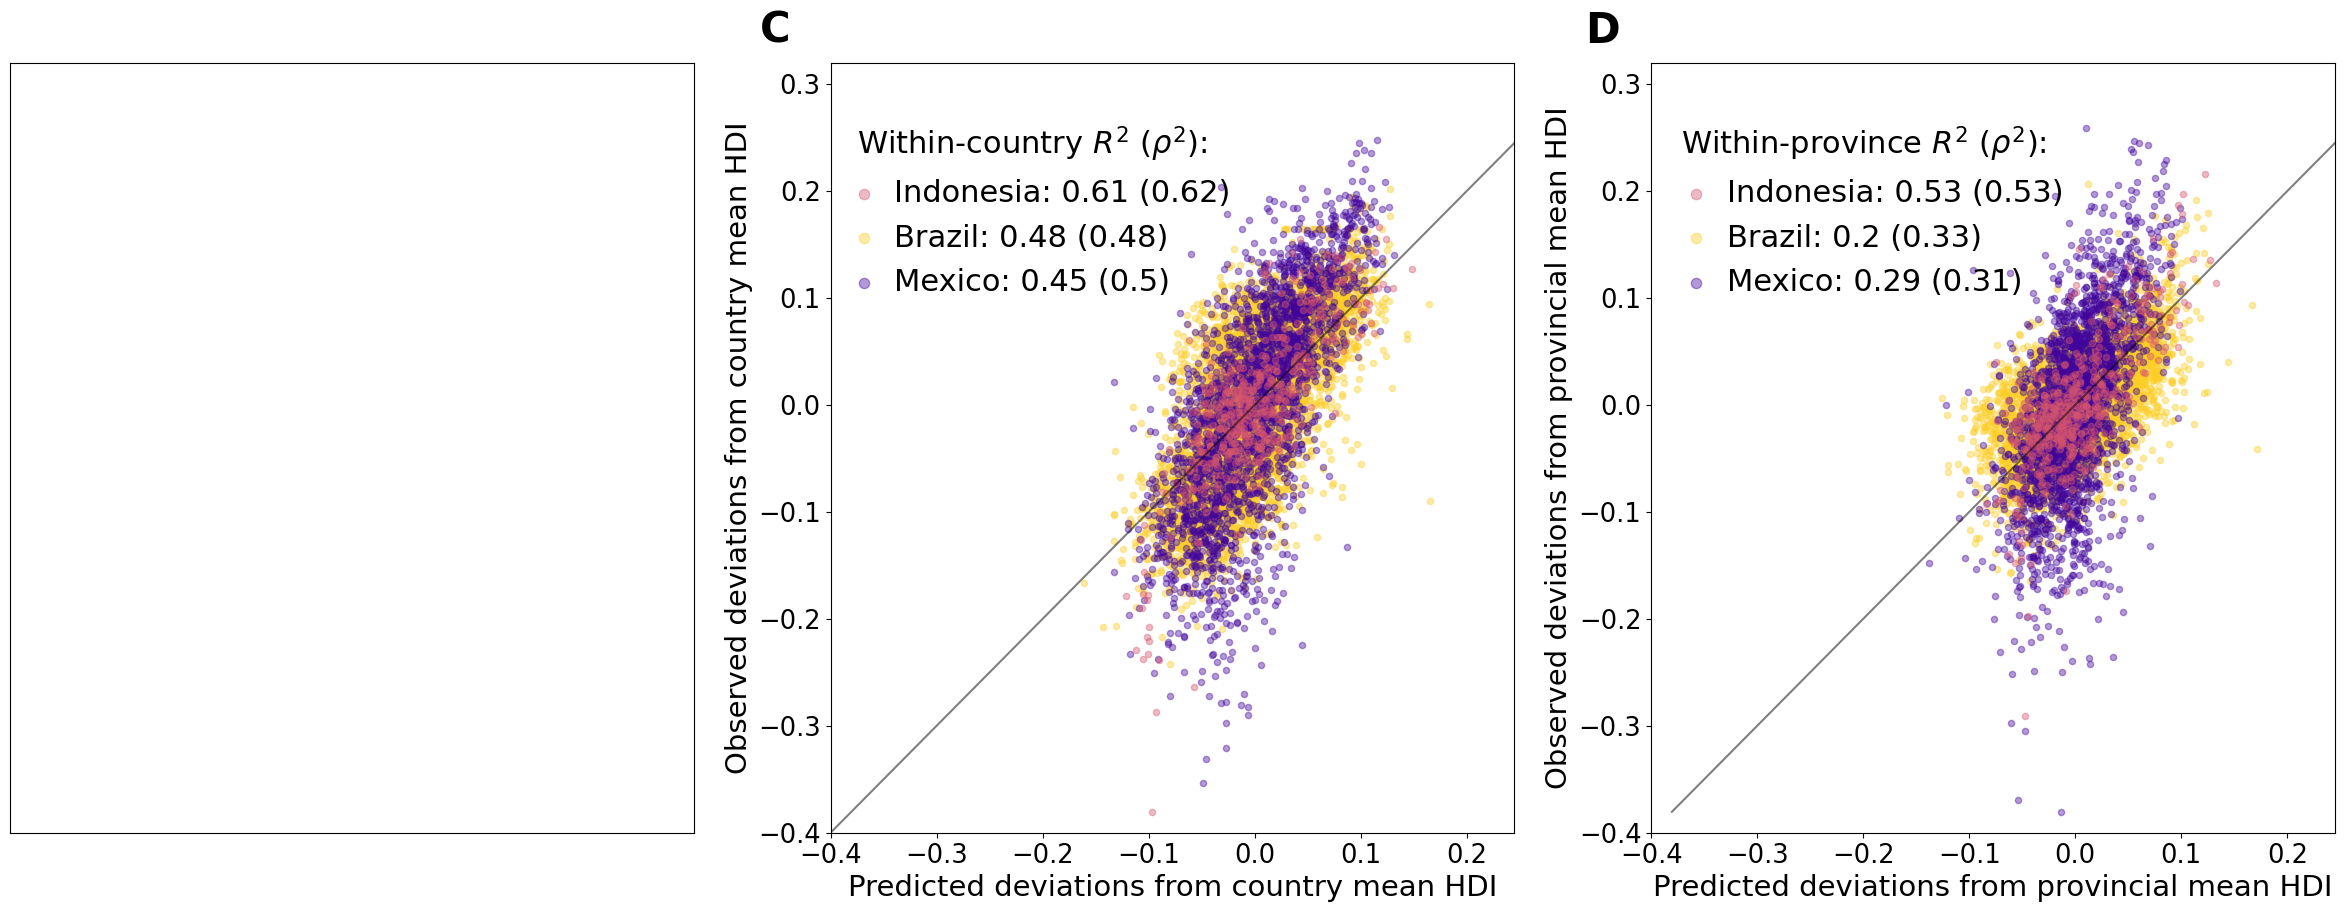

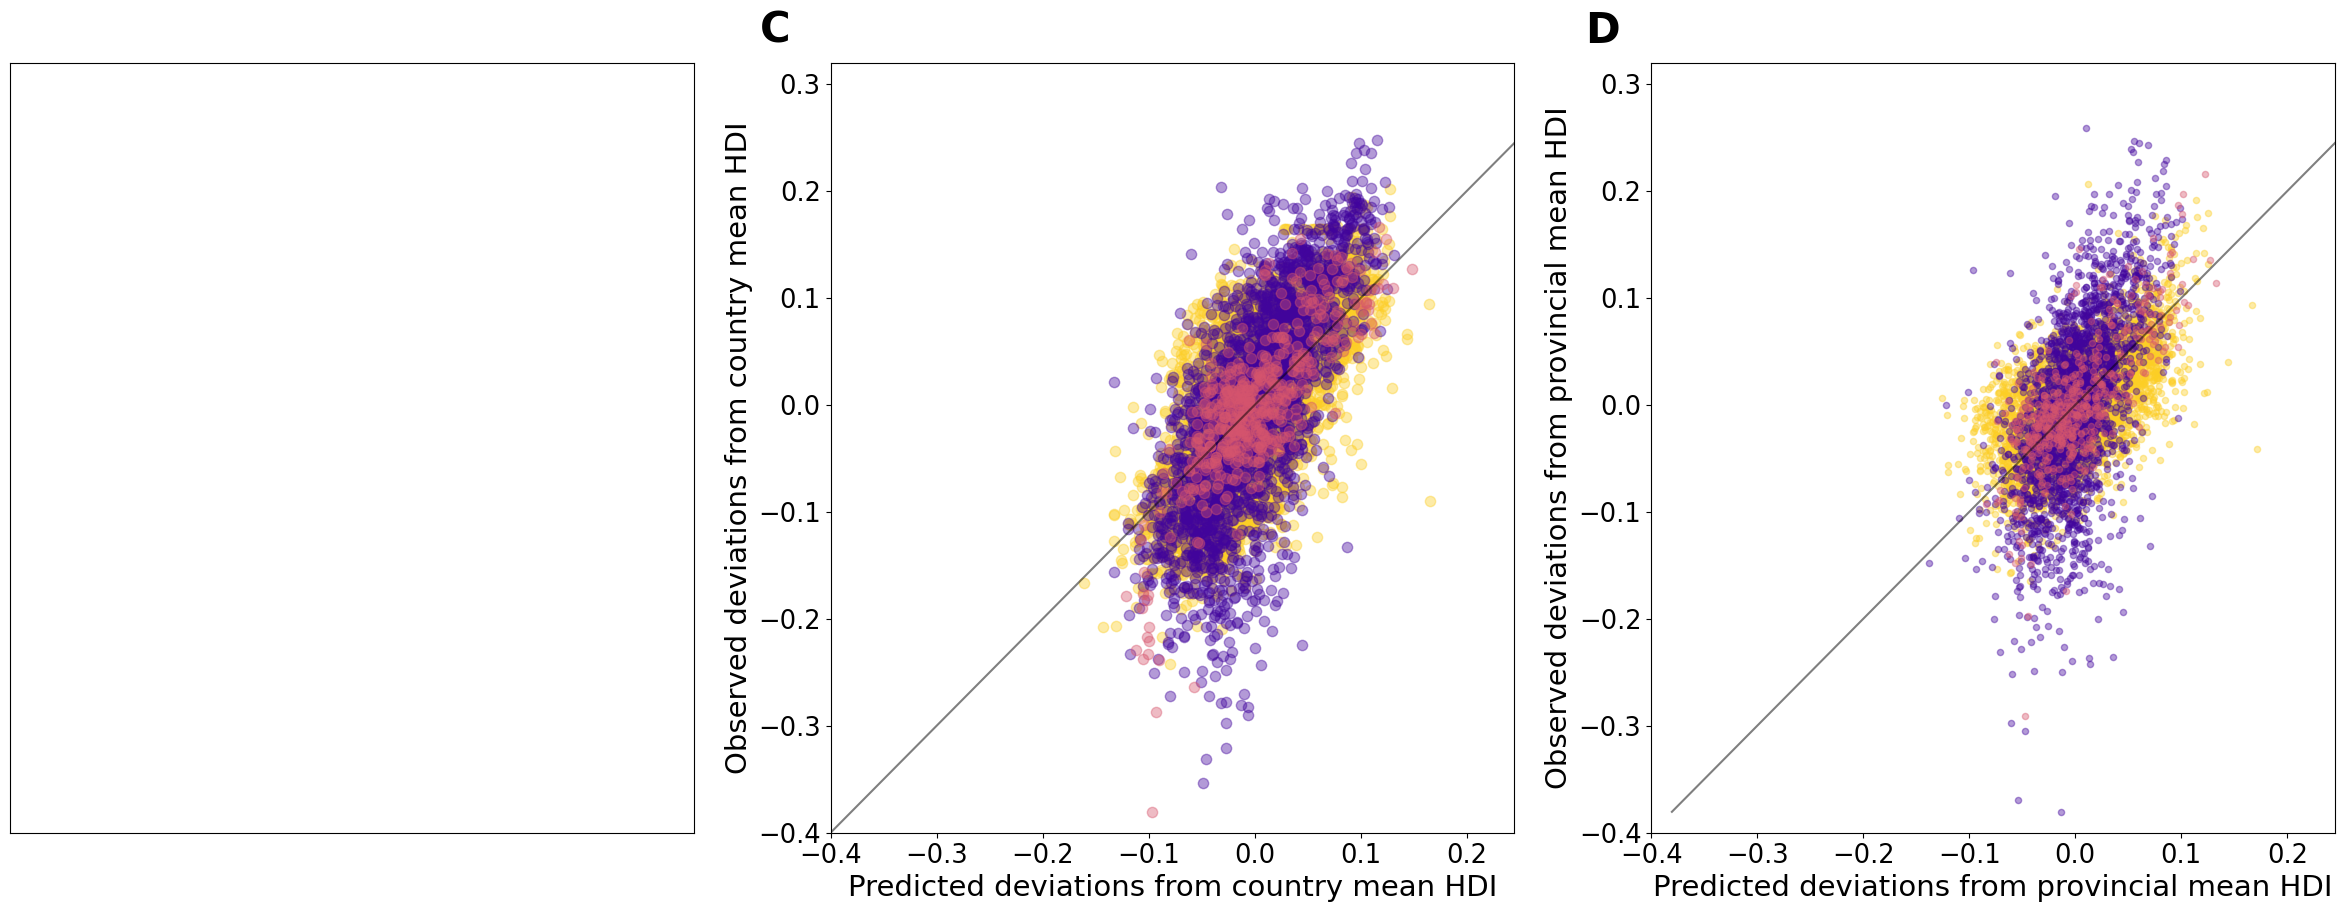

In [15]:
cmap = matplotlib.cm.get_cmap('plasma')

color1 = cmap(0.55)
color2 = cmap(0.9)
color3 = cmap(0.1)

fig2, ax = plt.subplots(1,3, figsize = (30,10))


# ax[0].plot([adm2_df.true_centered, adm2_df.true_centered],[adm2_df.true_centered, adm2_df.true_centered], color='black', alpha=.5)  

# ax[0].scatter(brazil_df.adm2_pred, brazil_df.true_centered, color = color2, alpha=.3, s=15, rasterized=True, label="Brazil")
# ax[0].scatter(mex_df.adm2_pred, mex_df.true_centered, color = color3, alpha=.3, s=15, rasterized=True, label="Mexico")
# ax[0].scatter(ind_df.adm2_pred,ind_df.true_centered, color = color1, alpha=.3, s=20, rasterized=True, label="Indonesia")


# ax[0].set_xlabel("Predicted HDI", size=axis_label_size)
# ax[0].set_ylabel("Observed HDI", size=axis_label_size)


# r2 = sklearn.metrics.r2_score(adm2_df.true_centered, adm2_df.adm2_pred)
# rho = np.corrcoef(adm2_df.true_centered, adm2_df.adm2_pred)[0,1] **2

# ax0_text = "$R^{2}$: " + str(r2.round(2)) + "\n \n" + r"$ρ^{2}$: " + str(rho.round(2))


ax[1].plot([adm2_df.truth.min(), adm2_df.truth.max()],[adm2_df.truth.min(), adm2_df.truth.max()], color='black', alpha=.5)  

ax[1].scatter(brazil_df.preds, brazil_df.truth, color = color2, alpha=.4, s=20, rasterized=True, label="Brazil")
ax[1].scatter(mex_df.preds, mex_df.truth, color = color3, alpha=.4, s=20, rasterized=True, label="Mexico")
ax[1].scatter(ind_df.preds,ind_df.truth, color = color1, alpha=.4, s=20, rasterized=True, label="Indonesia")


ax[1].set_xlabel("Predicted deviations from country mean HDI", size=axis_label_size)
ax[1].set_ylabel("Observed deviations from country mean HDI", size=axis_label_size)


brazil_r2 = sklearn.metrics.r2_score(brazil_df.truth, brazil_df.preds)
brazil_rho = np.corrcoef(brazil_df.truth, brazil_df.preds)[0,1] **2
mex_r2 = sklearn.metrics.r2_score(mex_df.truth, mex_df.preds)
mex_rho = np.corrcoef(mex_df.truth, mex_df.preds)[0,1] **2
ind_r2 = sklearn.metrics.r2_score(ind_df.truth,ind_df.preds)
ind_rho = np.corrcoef(ind_df.truth, ind_df.preds)[0,1] **2

brazil_label = "Brazil: " + str(round(brazil_r2,2)) + " (" + str(round(brazil_rho,2)) +")"
mex_label = "Mexico: " + str(round(mex_r2,2)) + " (" + str(round(mex_rho,2)) +")"
ind_label = "Indonesia: " + str(round(ind_r2,2)) + " (" + str(round(ind_rho,2)) +")"

within_country_labels = [ind_label,brazil_label, mex_label]

if r2 < 0:
    r2_str = "< 0"
else:
    r2_str = str(r2.round(2))

#ax1_text = "Within-country $R^{2}$: " + r2_str + "\n \n" + r"Within-country $ρ^{2}$: " + str(rho.round(2))

ax[2].plot([adm2_df.true_demean.min(), adm2_df.true_demean.max()],[adm2_df.true_demean.min(), adm2_df.true_demean.max()],
           color='black', alpha=.5)  

ax[2].scatter(brazil_df.preds_demean, brazil_df.true_demean, color = color2, alpha=.4, s=20, rasterized=True)
ax[2].scatter(mex_df.preds_demean, mex_df.true_demean, color = color3, alpha=.4, s=20, rasterized=True)
ax[2].scatter(ind_df.preds_demean, ind_df.true_demean, color = color1, alpha=.4, s=20, rasterized=True)

ax[2].set_xlabel("Predicted deviations from provincial mean HDI", size=axis_label_size)
ax[2].set_ylabel("Observed deviations from provincial mean HDI", size=axis_label_size)

brazil_r2 = sklearn.metrics.r2_score(brazil_df.true_demean, brazil_df.preds_demean)
brazil_rho = np.corrcoef(brazil_df.true_demean, brazil_df.preds_demean)[0,1] **2
mex_r2 = sklearn.metrics.r2_score(mex_df.true_demean, mex_df.preds_demean)
mex_rho = np.corrcoef(mex_df.true_demean, mex_df.preds_demean)[0,1] **2
ind_r2 = sklearn.metrics.r2_score(ind_df.true_demean,ind_df.preds_demean)
ind_rho = np.corrcoef(ind_df.true_demean, ind_df.preds_demean)[0,1] **2

brazil_label = "Brazil: " + str(round(brazil_r2,2)) + " (" + str(round(brazil_rho,2)) +")"
mex_label = "Mexico: " + str(round(mex_r2,2)) + " (" + str(round(mex_rho,2)) +")"
ind_label = "Indonesia: " + str(round(ind_r2,2)) + " (" + str(round(ind_rho,2)) +")"

within_province_labels = [ind_label, brazil_label, mex_label]


r2 = sklearn.metrics.r2_score(adm2_df.true_demean, adm2_df.preds_demean)
rho = np.corrcoef(adm2_df.true_demean, adm2_df.preds_demean)[0,1] ** 2

if r2 < 0:
    r2_str = "< 0"
else:
    r2_str = str(r2.round(2))

ax2_text = "Within-province $R^{2}$: " + r2_str + "\n \n" + r"Within-province $ρ^{2}$: " + str(rho.round(2))

# ax[1].set_title("Within-country performance", size=plot_title_size)
# ax[2].set_title("Within-province performance", size=plot_title_size)

handles, labels = ax[0].get_legend_handles_labels()

ax[1].set_xlim((-0.4,0.245))
ax[2].set_xlim((-0.4,0.245))

ax[1].set_ylim((-0.4,0.32))
ax[2].set_ylim((-0.4,0.32))

ax[0].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)


fig2.text(.375,.9,"C",size = 30,fontweight='bold',)
fig2.text(.65,.9,"D",size = 30,fontweight='bold',)


# fig2.text(.415,.70, ax1_text, size = performance_size)
# fig2.text(.69,.70, ax2_text, size = performance_size)


#fig2.suptitle("HDI predicted at the municipality level in Indonesia, Mexico, Brazil (n={:,})".format(len(adm2_df)),
#              size=sup_title_size, fontweight=100, x =.65)

handles, _ = ax[1].get_legend_handles_labels()
handles  = copy.deepcopy(handles)
handles = [handles[2], handles[0], handles[1]]

_ = [h.set_sizes(np.array([55])) for h in handles]

fig2.legend(handles, within_country_labels, loc=(.35,.661), ncol=1,
            prop={'size': performance_size}, 
            title=r"Within-country $R^2$ ($\rho^2$):", title_fontsize=performance_size,
           frameon=False,
           handletextpad=0)

fig2.legend(handles, within_province_labels, loc=(.705,.661), ncol=1,
            prop={'size': performance_size}, 
            title=r"Within-province $R^2$ ($\rho^2$):", title_fontsize=performance_size,
           frameon=False,
           handletextpad=0)

# fig2.text(.14,.70, ax0_text, size = performance_size)

fig2.savefig(repo_dir + "figures/Fig2_HDI_adm2_scatter.pdf", dpi=300,transparent=True, bbox_inches="tight")

### Get data for IWI scatters

In [16]:
iwi_path = data_dir + "preds/demean_iwi_rcf_nl_at_dhs_NO_DHSID.p"

In [17]:
iwi_df = pd.read_pickle(iwi_path) #created in Subnat_IWI_and_GNI_Predict_V2.ipynb

cmap = matplotlib.cm.get_cmap('plasma')
color = cmap(0.1)

/tmp/ipykernel_23590/1758450490.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


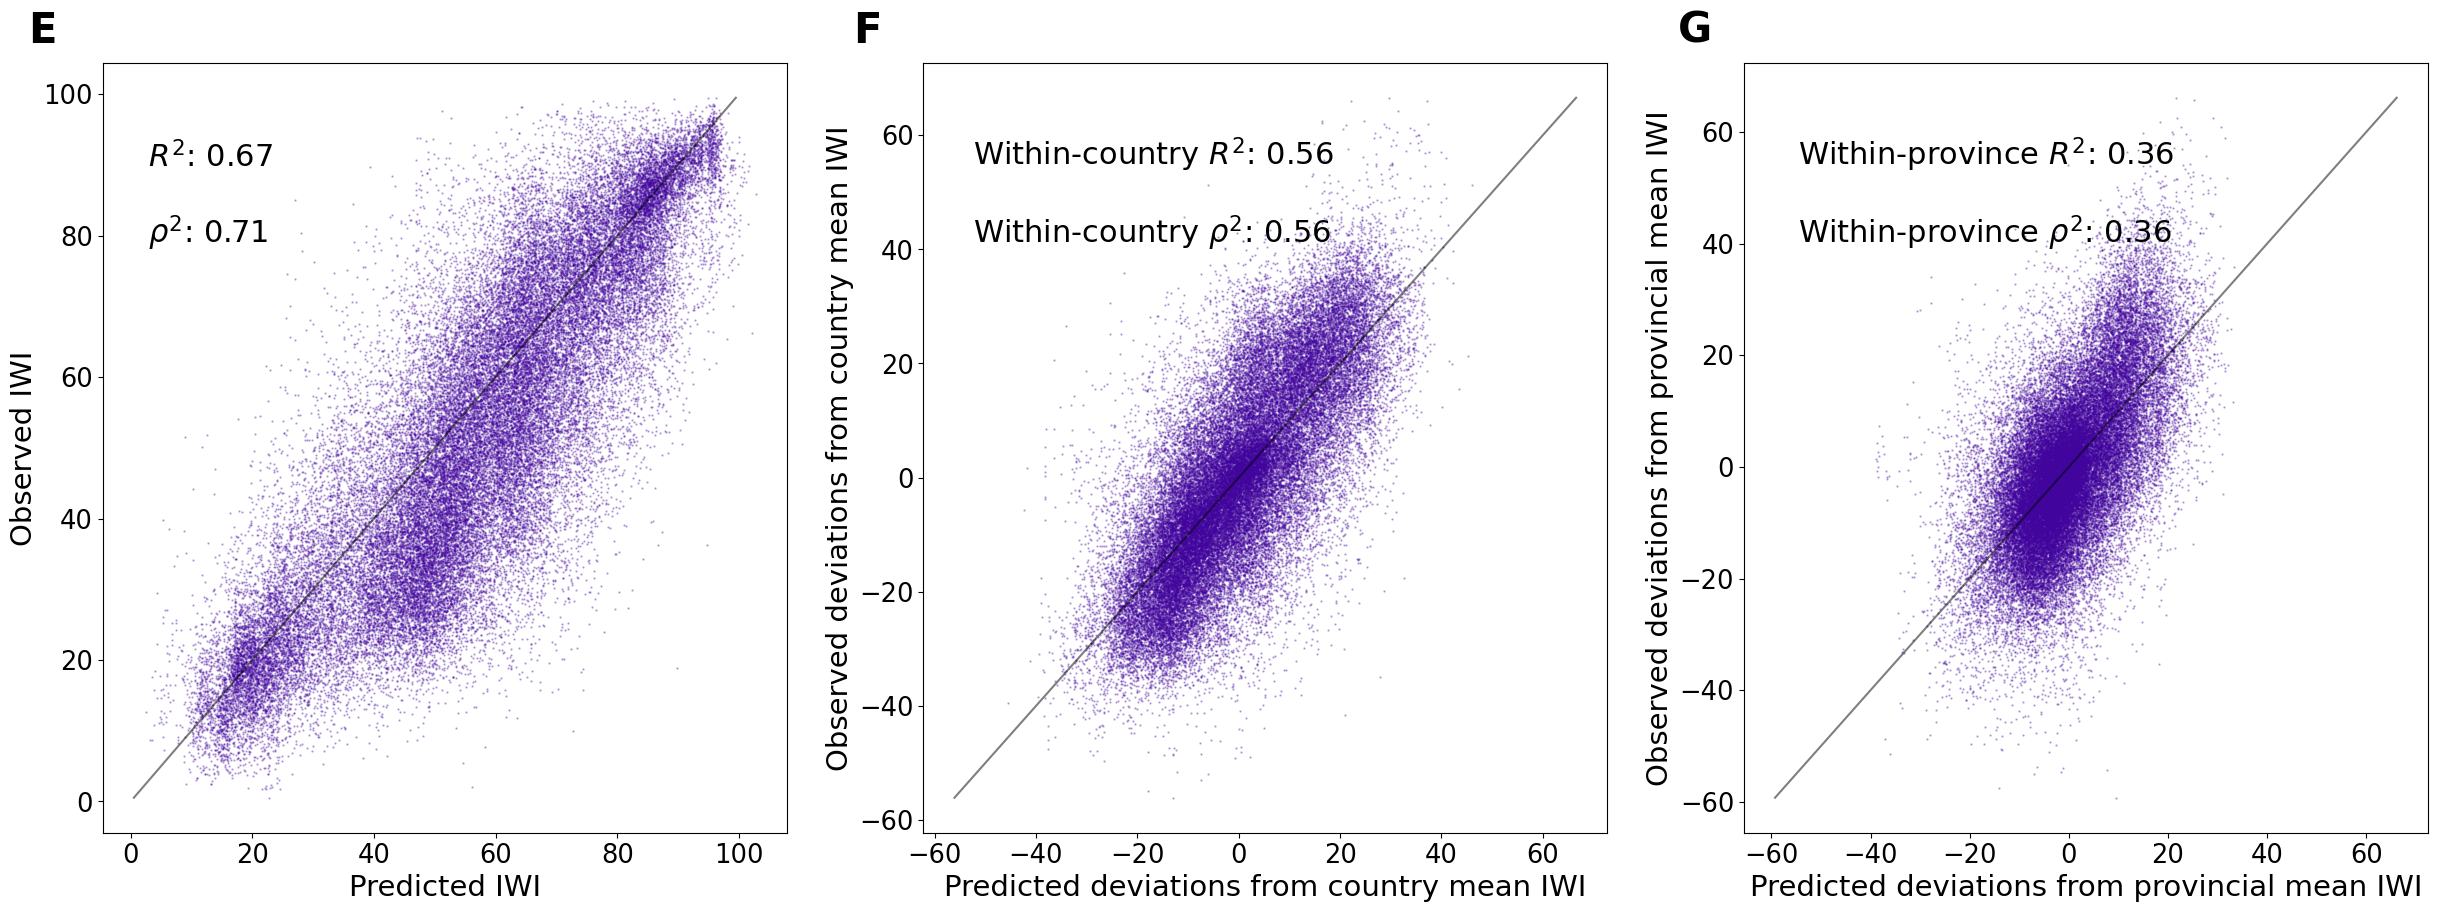

In [18]:
preds = iwi_df.preds
truth = iwi_df.truth


fig3, ax = plt.subplots(1,3, figsize = (30,10))
################################################################################

ax[0].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[0].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)
#ax.set_title("Re-centered scatter")

r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax0_text = "$R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"$\rho^{2}$: " + str(rho.round(2))


ax[0].set_ylabel("Observed IWI", size=axis_label_size)

ax[0].set_xlabel("Predicted IWI", size=axis_label_size)

#ax[0].set_title("Full variation performance", size=plot_title_size)
############################################################
preds = iwi_df.preds_demean_adm0
truth = iwi_df.true_demean_adm0

ax[1].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[1].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)

r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax1_text = "Within-country $R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"Within-country $\rho^{2}$: " + str(rho.round(2))


ax[1].set_ylabel("Observed deviations from country mean IWI", size=axis_label_size)

ax[1].set_xlabel("Predicted deviations from country mean IWI", size=axis_label_size)

# ax[1].set_title("Within-country performance", size=plot_title_size)

############################################################
preds = iwi_df.preds_demean_adm1
truth = iwi_df.true_demean_adm1


ax[2].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[2].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)
#ax.set_title("Re-centered scatter")

r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax2_text = "Within-province $R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"Within-province $\rho^{2}$: " + str(rho.round(2))

# ax[2].set_xlim(preds.min(), preds.max())
# ax[2].set_ylim(truth.min(), truth.max())

ax[2].set_xlabel("Predicted deviations from provincial mean IWI", size=axis_label_size)

ax[2].set_ylabel("Observed deviations from provincial mean IWI", size=axis_label_size)

# ax[2].set_title("Within-province performance", size= plot_title_size)

# fig3.suptitle("IWI predicted at DHS cluster level (n={:,})".format(len(iwi_df)),size=sup_title_size, fontweight=100)

fig3.text(.1,.9,"E",size = 30,fontweight='bold',)
fig3.text(.375,.9,"F",size = 30,fontweight='bold',)
fig3.text(.65,.9,"G",size = 30,fontweight='bold',)

# fig3.text(.14,.78,"test",size=40)

# fig3.text(.415,.78,"test",size=40)

# fig3.text(.415,.78,"test",size=40)

fig3.text(.14,.70, ax0_text, size = performance_size)
fig3.text(.415,.70, ax1_text, size = performance_size)
fig3.text(.69,.70, ax2_text, size = performance_size)


#fig3.text(.69,.78,"test",size=40)

fig3.savefig(repo_dir + "figures/Fig2_IWI_scatter.pdf", dpi=200,transparent=True)

### Make NL experiment scatters

In [19]:
nl_path = data_dir + "int/VIIRS/nl_adm2_preds_recenter=adm0_dropIreland=True_extra_clip=False.p"

drop_ireland = "dropIreland=True" in nl_path
recenter = "adm0"
if "recenter=adm1" in nl_path:
    recenter="adm1"

In [20]:
nl_df = pd.read_pickle(nl_path) #created in Subnat_IWI_and_GNI_Predict_V2.ipynb


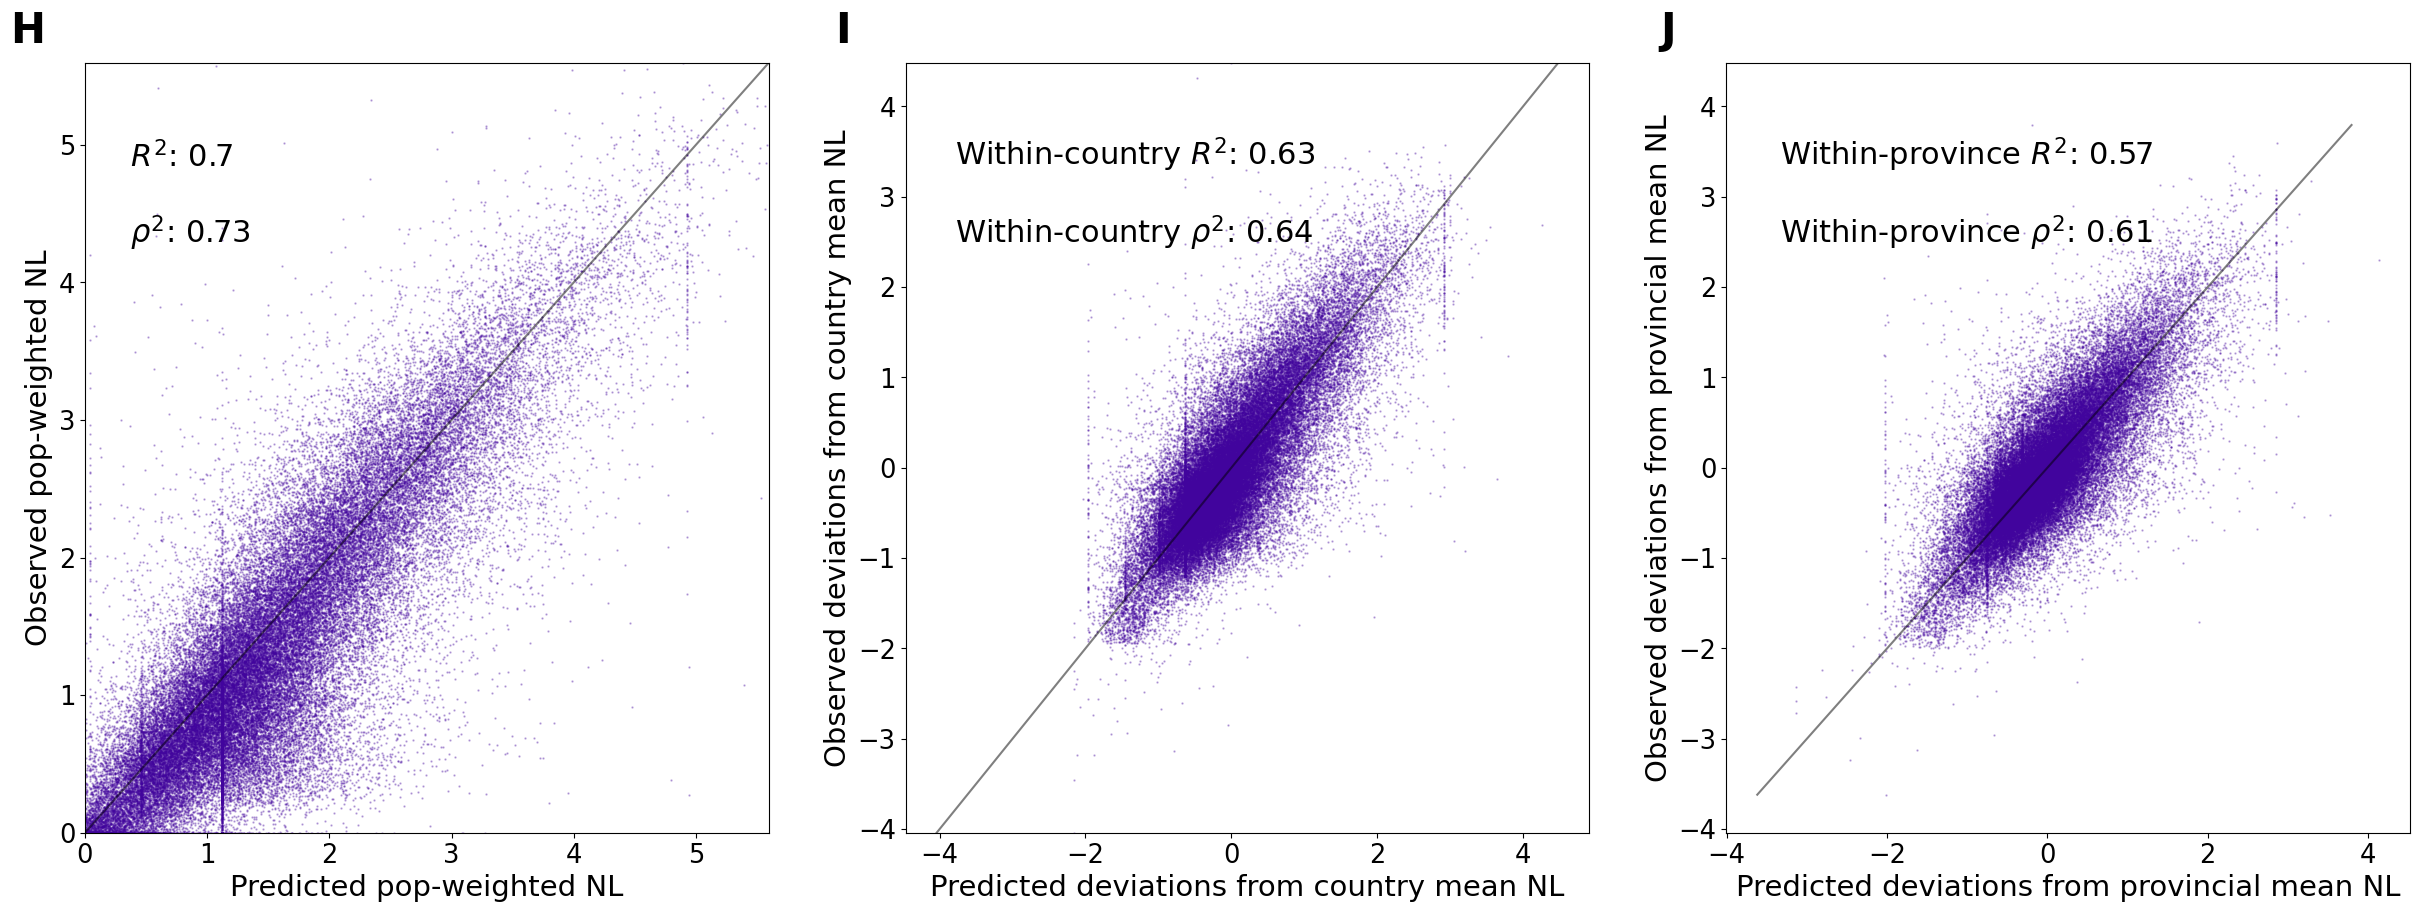

In [21]:
preds = nl_df.preds
truth = nl_df.truth


fig4, ax = plt.subplots(1,3, figsize = (30,10))
################################################################################

ax[0].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[0].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)
#ax.set_title("Re-centered scatter")

r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax0_text = "$R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"$\rho^{2}$: " + str(rho.round(2))


ax[0].set_ylabel("Observed pop-weighted NL", size=axis_label_size)

ax[0].set_xlabel("Predicted pop-weighted NL", size=axis_label_size)

ax[0].set_xlim(truth.min(),truth.max())

# ax[0].set_title("Full variation performance", size=plot_title_size)
############################################################
preds = nl_df.preds_demean_adm0
truth = nl_df.true_demean_adm0

ax[1].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[1].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)
#ax.set_title("Re-centered scatter")

r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax1_text = "Within-country $R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"Within-country $\rho^{2}$: " + str(rho.round(2))



ax[1].set_ylabel("Observed deviations from country mean NL", size=axis_label_size)

ax[1].set_xlabel("Predicted deviations from country mean NL", size=axis_label_size)

# ax[1].set_title("Within-country performance", size=plot_title_size)

############################################################
preds = nl_df.preds_demean_adm1
truth = nl_df.true_demean_adm1


ax[2].plot([truth.min(), truth.max()],[truth.min(), truth.max()], color='black', alpha=.5)  

ax[2].scatter(preds, truth, s=.5, alpha=.3, color=color, rasterized=True)


r2 = sklearn.metrics.r2_score(truth, preds)
rho = np.corrcoef(truth, preds)[0,1] ** 2


ax2_text = "Within-province $R^{2}$: " + str(r2.round(2)) + "\n" +"\n"+ r"Within-province $\rho^{2}$: " + str(rho.round(2))


ax[0].set_ylim(nl_df.truth.min(), nl_df.truth.max())

ax[1].set_ylim(nl_df.true_demean_adm0.min(), nl_df.true_demean_adm0.max())

ax[2].set_ylim(nl_df.true_demean_adm0.min(), nl_df.true_demean_adm0.max())

ax[2].set_xlabel("Predicted deviations from provincial mean NL", size=axis_label_size)
ax[2].set_ylabel("Observed deviations from provincial mean NL", size=axis_label_size)

# ax[2].set_title("Within-province performance", size= plot_title_size)

# fig4.suptitle("NL predicted at municipality level (n={:,})".format(len(nl_df)),size=sup_title_size, fontweight=100)

fig4.text(.1,.9,"H",size = 30,fontweight='bold',)
fig4.text(.375,.9,"I",size = 30,fontweight='bold',)
fig4.text(.65,.9,"J",size = 30,fontweight='bold',)

fig4.text(.14,.70, ax0_text, size = performance_size)
fig4.text(.415,.70, ax1_text, size = performance_size)
fig4.text(.69,.70, ax2_text, size = performance_size)

fig4.savefig(repo_dir + f"figures/Fig2_nl_scatter_dropIreland={drop_ireland}+recenter={recenter}.pdf", dpi=300,transparent=True)